In [1]:
import numpy as np
import matplotlib.pyplot as plt
class Diana(object):
    def __init__(self,length):
        self.data_lists = []#数据集
        self.datas_length = 0#数据集大小
        self.dissimilarity_matrix = []#点之间的相异矩阵
        self.point_index_list = []#点的序号
        self.current_clusters = []#簇
        self.load_dataset('Experiment2/data/temp.csv',length)
        self.get_dissimilarity_matrix()
        self.clusters_core = []# 聚类核心

    """
    加载数据集    latitude longitude
    """

    def load_dataset(self,filename,length):
        r = open(filename, 'r')
        datas = r.readlines()
        list = []
        del (datas[0])
        for i in range(0, len(datas)):
            temp_list = datas[i].split(',')
            if float(temp_list[1]) > -15 and  float(temp_list[2]) < -36.9 :
                list.append((float(temp_list[1]), float(temp_list[2])))
            if i > length:
                break
        self.data_lists = list
        self.datas_length = len(list)

    """
    计算两个向量的距离
    """
    def dist(self,vec1, vec2):
        # dist = distance(vec1, vec2).miles
        dist = np.sqrt(np.sum(np.square(np.array(vec1) - np.array(vec2))))
        return dist

    """
    计算相异矩阵  二维矩阵 存放两两点之间的距离
    顺便生成每个点的序号 与矩阵的index相对应
    """
    def get_dissimilarity_matrix(self):
        self.dissimilarity_matrix = np.zeros((self.datas_length,self.datas_length))
        for i in range(0,self.datas_length):
            for j in range(0,self.datas_length):
                #计算每两个点的距离 然后存入相异性矩阵
                dist_i_j = self.dist(self.data_lists[i],self.data_lists[j])
                self.dissimilarity_matrix[i][j]  = dist_i_j


        #计算每个点的序号
        for i in range(0, self.datas_length):
            self.point_index_list.append(i)
    """
    计算某一个簇内的点 与簇内其他点的平均相异度  
    参数ele为簇内的某个点的标号
    element为这个簇内的所有点的标号
    """
    def avg_dissimilar_within_group_element(self,ele, element_list):
        # max_diameter = -np.inf
        sum_dissm = 0
        for i in element_list:
            sum_dissm += self.dissimilarity_matrix[ele][i]
            # if (self.dissimilarity_matrix[ele][i] > max_diameter):
            #     max_diameter = self.dissimilarity_matrix[ele][i]
        if (len(element_list) > 1):
            avg = sum_dissm / (len(element_list) - 1)
        else:
            avg = 0
        return avg

    """
      计算某一个簇内的点 与不再这个簇的点的平均距离
      ele为簇内的某个点的标号
      element为不在这个簇内的元素
      """

    def avg_dissimilar_across_group_element(self,ele, splinter_list):
        if len(splinter_list) == 0:
            return 0
        sum_dissm = 0
        for j in splinter_list:
            sum_dissm = sum_dissm + self.dissimilarity_matrix[ele][j]
        avg = sum_dissm / (len(splinter_list))
        return avg

    """
       计算某一个簇内的点 与簇内其他点的最短距离
       参数ele为簇内的某个点的标号
       element_list为这个簇内的所有点的标号
       """

    def min_dist_within_group_element(self, ele, element_list):
        min_dist = np.inf
        min_dist_index = -1
        #找到最近距离的点 的距离
        for i in element_list:

            if self.dissimilarity_matrix[ele][i] < min_dist and i != ele:
                min_dist = self.dissimilarity_matrix[ele][i]
                min_dist_index = i
        return min_dist

    """
      计算某一个簇内的点 与不再这个簇的点的最短距离
      ele为簇内的某个点的标号
      splinter_list为不在这个簇内的元素的标号
      """

    def min_dist_across_group_element(self, ele, splinter_list):
        if len(splinter_list) == 0:
            return 200
        min_dist = np.inf
        min_dist_index = -1
        # 找到最近距离的点 的距离
        for i in splinter_list:

            if self.dissimilarity_matrix[ele][i] < min_dist and i != ele:
                min_dist = self.dissimilarity_matrix[ele][i]
                min_dist_index = i
        return min_dist

    """
        将一个簇划分为两个  
        element_list为等待划分的元素标号
        old_party, splinter_group为划分结果
    """
    def split(self,element_list):
        #切分的元素列表
        old_party = element_list

        splinter_group = []
        #计算最大平均相异度的点 most_dissm_object_index   flag为是否还能继续划分
        most_dissm_object_index, flag =self.splinter_avg_dissimilar(old_party, splinter_group)
        #flag为是否还能继续划分 flag =1说明还能继续划分  flag=-1不能继续划分
        while (flag > 0):
            old_party.remove(most_dissm_object_index)
            splinter_group.append(most_dissm_object_index)
            most_dissm_object_index, flag = self.splinter_min_dist(old_party, splinter_group)
        return old_party, splinter_group

    """
           判断old_party中的元素是否要被划分到splinter_group
           采用计算old_party中的点element的在old_party平均相异度  和  element在splinter_group的平均相异度，
           如果后者小于前者 则将element加入splinter_group
        """
    def splinter_avg_dissimilar(self,old_party, splinter_group):
            most_dissm_object_value = -np.inf
            most_dissm_object_index = None
            for ele in old_party:
                x = self.avg_dissimilar_within_group_element(ele, old_party)#在old_party中的某个元素ele 与old_party中其他元素的平均相异度
                y = self.avg_dissimilar_across_group_element(ele, splinter_group)#在old_party中的某个元素ele 与splinter_group中元素的平均相异度
                #diff为正 说明 这个点需要被划分出去  如果为负 说明不需要继续划分了
                diff = x - y
                #计算x与y的最大差  和取得此差的元素标号
                if diff > most_dissm_object_value:
                    most_dissm_object_value = diff
                    most_dissm_object_index = ele
            # 如果x与y的最大差为正 说明 这个点需要被划分出去  如果为负 说明ele与old_party中的元素 相异度更小 说明不需要继续划分了
            if most_dissm_object_value > 0:
                return most_dissm_object_index, 1
            else:
                return -1, -1

    """
              判断old_party中的元素是否要被划分到splinter_group
              采用计算old_party中的点element与old_party中的其他点的最小距离  和 
               element与splinter_group中的点的最小距离
              如果后者小于前者 则将element加入splinter_group
           """
    def splinter_min_dist(self, old_party, splinter_group):
        most_dissm_object_value = np.inf
        most_dissm_object_index = None
        for ele in old_party:
            x = self.min_dist_within_group_element(ele,old_party)  # 在old_party中的某个元素ele 与old_party中其他元素的平均相异度
            y = self.min_dist_across_group_element(ele,splinter_group)  # 在old_party中的某个元素ele 与splinter_group中元素的平均相异度
            # diff为正 说明 这个点需要被划分出去  如果为负 说明不需要继续划分了
            diff = x - y
            # 计算x与y的最大差  和取得此差的元素标号
            if y == 200:
                if diff < most_dissm_object_value:
                            most_dissm_object_value = diff
                            most_dissm_object_index = ele
            elif diff > 0 :
                if diff < most_dissm_object_value:
                    most_dissm_object_value = diff
                    most_dissm_object_index = ele

        # 如果x与y的最大差为负 说明 这个点需要被划分出去  如果为正 说明ele与old_party中的元素 相异度更小 
        # 说明不需要继续划分了
        if most_dissm_object_value < 0:
            return most_dissm_object_index, 1
        else:
            return -1, -1

    """
    计算具有最大直径的簇  作为下次被划分的簇
    """
    def max_diameter(self):
        max_diameter_cluster_index = None
        max_diameter_cluster_value = -np.inf
        index = 0
        for element_list in self.current_clusters:
            for i in element_list:
                for j in element_list:
                    if self.dissimilarity_matrix[i][j] > max_diameter_cluster_value:
                        max_diameter_cluster_value = self.dissimilarity_matrix[i][j]
                        max_diameter_cluster_index = index

            index += 1

        if (max_diameter_cluster_value <= 0):
            return -1

        return max_diameter_cluster_index

    def plotRes(self):

        scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'm', 'fuchsia',
                         'crimson', 'dodgerblue', 'lime', 'coral', 'peru', 'khaki', 'black', 'blue', 'green', 'yellow',
                         'red', 'purple', 'orange', 'brown', 'm', 'fuchsia', 'crimson', 'dodgerblue', 'lime', 'coral',
                         'peru', 'khaki', 'black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown', 'm',
                         'fuchsia', 'crimson', 'dodgerblue', 'lime', 'coral', 'peru', 'khaki']
        x = 0
        for i in self.current_clusters:
            for j in i:
                plt.scatter(self.data_lists[j][0], self.data_lists[j][1], c=scatterColors[x],
                            alpha=1, marker='+')
            x +=1
        plt.title("Diana Clustering")
        plt.show()

In [2]:
# 聚类平均距离
def avg_dis(cluster):
    sum = 0.0
    if len(cluster) == 1:
        return 0
    for i in cluster:
        for j in cluster:
            sum += diana.dist(diana.data_lists[i], diana.data_lists[j])
    l = len(cluster)  # 聚类点的个数
    return sum / (l * (l - 1))


def compute_Rij(i, j, k, cluster_res, cluster_core):
    avg_ci = avg_dis(cluster_res[i])
    avg_cj = avg_dis(cluster_res[j])
    dcen = diana.dist(cluster_core[i], cluster_core[j])  # 两个聚类核心点的距离
    res = (avg_ci + avg_cj) / dcen
    return res


def compute_max(index, cluster_res, k, cluster_core):
    list_r = []
    for j in range(0, k):
        if index != j:
            temp = compute_Rij(index, j, k, cluster_res, cluster_core)
            list_r.append(temp)
    return max(list_r)


def computer_db_index(cluster_res, cluster_core):
    k = len(cluster_core)  # 聚类总数
    sigma_R = 0.0
    for i in range(0, k):
        sigma_R += compute_max(i, cluster_res, k, cluster_core)
    dbi = float(sigma_R) / float(k)
    return dbi


数据点的个数为: 300     簇的个数为： 10


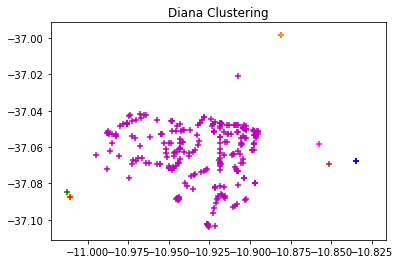

簇的db指数为 0.4496873406037675


In [3]:
diana = Diana(300)

# diana.load_dataset('data/temp.csv',500)
# diana.get_dissimilarity_matrix()
#簇
diana.current_clusters = ([diana.point_index_list])

#当前层数
level = 1
index = 0       #当前被划分的簇标记
k = 10
print("数据点的个数为:",300,"   ","簇的个数为：",k)
while index != -1 and level<k:
    # print(level, diana.current_clusters)
    #划分簇   直到满足条件 将一个簇分为两个
    a_clstr, b_clstr = diana.split(diana.current_clusters[index])
    #将已经被进一步划分的簇删除  然后加入划分后的簇
    del diana.current_clusters[index]
    diana.current_clusters.append(a_clstr)
    diana.current_clusters.append(b_clstr)
    #寻找具有最大直径的簇  将起作为下一次划分的对象
    index = diana.max_diameter()
    level += 1

# print(level, diana.current_clusters)

diana.plotRes()
#计算聚类核心
for i in diana.current_clusters:
    x = 0.0
    y = 0.0
    for j in i:
        x +=diana.data_lists[j][0]
        y += diana.data_lists[j][1]
    diana.clusters_core.append((x/len(i),y/len(i)))
dbi = computer_db_index(diana.current_clusters,diana.clusters_core)
print('簇的db指数为',dbi)

数据点的个数为: 300     簇的个数为： 15


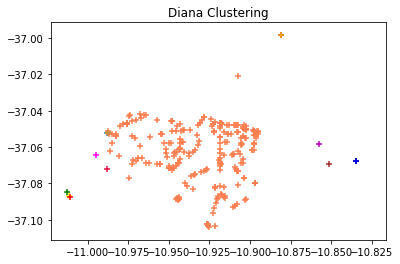

簇的db指数为 0.5023735717088336


In [4]:
diana = Diana(300)

# diana.load_dataset('data/temp.csv',500)
# diana.get_dissimilarity_matrix()
#簇
diana.current_clusters = ([diana.point_index_list])

#当前层数
level = 1
index = 0       #当前被划分的簇标记
k = 15
print("数据点的个数为:",300,"   ","簇的个数为：",k)
while index != -1 and level<k:
    # print(level, diana.current_clusters)
    #划分簇   直到满足条件 将一个簇分为两个
    a_clstr, b_clstr = diana.split(diana.current_clusters[index])
    #将已经被进一步划分的簇删除  然后加入划分后的簇
    del diana.current_clusters[index]
    diana.current_clusters.append(a_clstr)
    diana.current_clusters.append(b_clstr)
    #寻找具有最大直径的簇  将起作为下一次划分的对象
    index = diana.max_diameter()
    level += 1

# print(level, diana.current_clusters)

diana.plotRes()
#计算聚类核心
for i in diana.current_clusters:
    x = 0.0
    y = 0.0
    for j in i:
        x +=diana.data_lists[j][0]
        y += diana.data_lists[j][1]
    diana.clusters_core.append((x/len(i),y/len(i)))
dbi = computer_db_index(diana.current_clusters,diana.clusters_core)
print('簇的db指数为',dbi)

数据点的个数为: 300     簇的个数为： 7


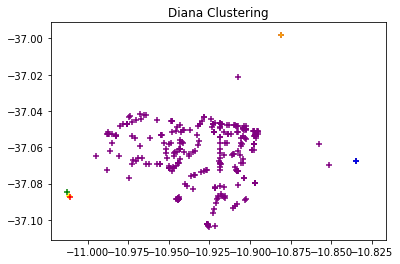

簇的db指数为 0.4418129634196343


In [5]:
diana = Diana(300)

# diana.load_dataset('data/temp.csv',500)
# diana.get_dissimilarity_matrix()
#簇
diana.current_clusters = ([diana.point_index_list])

#当前层数
level = 1
index = 0       #当前被划分的簇标记
k = 7
print("数据点的个数为:",300,"   ","簇的个数为：",k)
while index != -1 and level<k:
    # print(level, diana.current_clusters)
    #划分簇   直到满足条件 将一个簇分为两个
    a_clstr, b_clstr = diana.split(diana.current_clusters[index])
    #将已经被进一步划分的簇删除  然后加入划分后的簇
    del diana.current_clusters[index]
    diana.current_clusters.append(a_clstr)
    diana.current_clusters.append(b_clstr)
    #寻找具有最大直径的簇  将起作为下一次划分的对象
    index = diana.max_diameter()
    level += 1

# print(level, diana.current_clusters)

diana.plotRes()
#计算聚类核心
for i in diana.current_clusters:
    x = 0.0
    y = 0.0
    for j in i:
        x +=diana.data_lists[j][0]
        y += diana.data_lists[j][1]
    diana.clusters_core.append((x/len(i),y/len(i)))
dbi = computer_db_index(diana.current_clusters,diana.clusters_core)
print('簇的db指数为',dbi)

数据点的个数为: 500     簇的个数为： 15


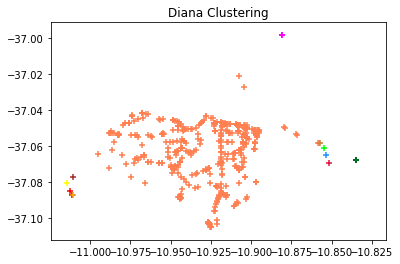

簇的db指数为 0.45188441919594674


In [6]:
diana = Diana(500)

# diana.load_dataset('data/temp.csv',500)
# diana.get_dissimilarity_matrix()
#簇
diana.current_clusters = ([diana.point_index_list])

#当前层数
level = 1
index = 0       #当前被划分的簇标记
k = 15
print("数据点的个数为:",500,"   ","簇的个数为：",k)
while index != -1 and level<k:
    # print(level, diana.current_clusters)
    #划分簇   直到满足条件 将一个簇分为两个
    a_clstr, b_clstr = diana.split(diana.current_clusters[index])
    #将已经被进一步划分的簇删除  然后加入划分后的簇
    del diana.current_clusters[index]
    diana.current_clusters.append(a_clstr)
    diana.current_clusters.append(b_clstr)
    #寻找具有最大直径的簇  将起作为下一次划分的对象
    index = diana.max_diameter()
    level += 1

# print(level, diana.current_clusters)

diana.plotRes()
#计算聚类核心
for i in diana.current_clusters:
    x = 0.0
    y = 0.0
    for j in i:
        x +=diana.data_lists[j][0]
        y += diana.data_lists[j][1]
    diana.clusters_core.append((x/len(i),y/len(i)))
dbi = computer_db_index(diana.current_clusters,diana.clusters_core)
print('簇的db指数为',dbi)

数据点的个数为: 500     簇的个数为： 25


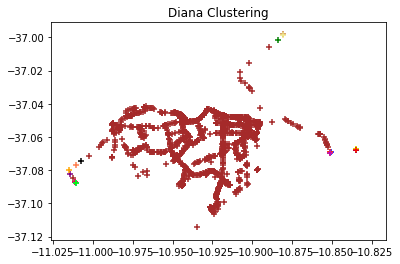

KeyboardInterrupt: 

In [7]:
diana = Diana(2000)

# diana.load_dataset('data/temp.csv',500)
# diana.get_dissimilarity_matrix()
#簇
diana.current_clusters = ([diana.point_index_list])

#当前层数
level = 1
index = 0       #当前被划分的簇标记
k = 25
print("数据点的个数为:",500,"   ","簇的个数为：",k)
while index != -1 and level<k:
    # print(level, diana.current_clusters)
    #划分簇   直到满足条件 将一个簇分为两个
    a_clstr, b_clstr = diana.split(diana.current_clusters[index])
    #将已经被进一步划分的簇删除  然后加入划分后的簇
    del diana.current_clusters[index]
    diana.current_clusters.append(a_clstr)
    diana.current_clusters.append(b_clstr)
    #寻找具有最大直径的簇  将起作为下一次划分的对象
    index = diana.max_diameter()
    level += 1

# print(level, diana.current_clusters)

diana.plotRes()
#计算聚类核心
for i in diana.current_clusters:
    x = 0.0
    y = 0.0
    for j in i:
        x +=diana.data_lists[j][0]
        y += diana.data_lists[j][1]
    diana.clusters_core.append((x/len(i),y/len(i)))
dbi = computer_db_index(diana.current_clusters,diana.clusters_core)
print('簇的db指数为',dbi)